In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as pt
import torch.nn as nn

import types
import numbers

# pt.autograd.set_detect_anomaly(False)


In [13]:
def showTraj(V_mat, F_mat, ts, target, figaxs=None, show=True, ax1_Title='Trajectory', alpha=0.5):
    if figaxs is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
    else:
        fig, (ax1, ax2) = figaxs

    VS = V_mat.detach().cpu().numpy() if isinstance(V_mat, pt.Tensor) else np.stack([_.detach() for _ in V_mat])
    FS = F_mat.detach().cpu().numpy()

    # lw = 2 if alpha == 1 else 0.75+alpha
    lw = 2 if alpha == 1 else 1.5

    ax1.plot(VS[:,0], VS[:,1], lw=lw, zorder=6, color='dodgerblue', alpha=alpha)

    ax2.plot(ts[:-1], FS[:,0], 'deeppink', lw=lw, alpha=alpha, label='Acceleration Force' if show else None)
    ax2.plot(ts[:-1], FS[:,1], 'limegreen', lw=lw, alpha=alpha, label='Turning Force' if show else None)


    if show:
        ax1.scatter(VS[0,0], VS[0,1], marker='*', color='sandybrown', s=200, zorder=6, label='Start')
        ax1.scatter(target[0], target[1], marker='s', color='sandybrown', s=120, label='Target')
        if alpha != 0:
            ax1.scatter(VS[-1,0], VS[-1,1], marker='o', color='dodgerblue', s=60, zorder=10, label='End', alpha=alpha)

        arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))

        ax1.arrow(*VS[-1,0:2], *arrowDir(VS[-1]), color='dodgerblue', head_width=0.1, head_length=0.1, lw=2, zorder=3, alpha=alpha)
        ax1.arrow(*target[0:2], *arrowDir(target.numpy()), color='sandybrown', head_width=0.15, head_length=0.15, lw=3, zorder=2)
        ax1.arrow(*VS[0,0:2], *arrowDir(VS[0]), color='sandybrown', head_width=0.15, head_length=0.15, lw=4, zorder=2)
        # ax1.arrow(*VS[0,0:2], *arrowDir(VS[0]), color='dodgerblue', head_width=0.1, head_length=0.1, lw=2, zorder=3)

        ax1.set_title(ax1_Title)
        ax1.set_xlabel('X Position')
        ax1.set_ylabel('Y Position')
        ax1.axis('equal')
        ax1.grid()
        ax1.legend()

        ax2.plot([0, 10], [-0.8, -0.8], '--k')
        ax2.plot([0, 10], [0.8, 0.8], '--k')
        ax2.legend()
        ax2.set_title('Forcing Terms')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Force')
        ax2.set_xlim([0, ts[-1]*1.1])
        ax2.set_ylim([-0.85, 0.85])
        ax2.grid()
        plt.show()

    return fig, (ax1, ax2)


In [3]:
def V_step(V, F):
    phi = F[0]  # linear acceleration
    psi = F[1]  # angluar acceleration
    dt = F[2]   # timestep size
    dt2 = dt*dt/2

    x = V[0]    # x coordinate
    y = V[1]    # y coordinate
    a = V[2]    # angle
    s = V[3]    # speed
    w = V[4]    # angular speed
    t = V[5]    # time

    _0 = pt.zeros_like(x)
    _1 = pt.ones_like(x)

    A1 = pt.stack([x, y, a, s, w, t])
    A2 = pt.stack([s*pt.cos(a), s*pt.sin(a), w, _0, _0, _0])
    A3 = pt.stack([-s*w*pt.sin(a), s*w*pt.cos(a), _0, _0, _0, _0])
    A = A1 + dt*A2 + dt2*A3

    B2 = pt.stack([_0, _0, _0, _1, _0, _0])
    B3 = pt.stack([pt.cos(a), pt.sin(a), _0, _0, _0, _0])
    B = dt*B2 + dt2*B3

    C2 = pt.stack([_0, _0, _0, _0, _1, _0])
    C3 = pt.stack([_0, _0, _1, _0, _0, _0])
    C = dt*C2 + dt2*C3

    D = pt.stack([_0, _0, _0, _0, _0, _1])  # this is correct

    # V1 = A + phi*B + psi*C + dt*D
    # return pt.clamp(V1, 
    #     min=pt.tensor([-pt.inf, -pt.inf, -pt.inf, 0, -2, -pt.inf]),
    #     max=pt.tensor([pt.inf, pt.inf, pt.inf, pt.inf, 2, pt.inf]))

    return A + phi*B + psi*C + dt*D

def angle_diff(theta1, theta2):
    diff = theta1 - theta2
    return (diff + np.pi) % (2 * np.pi) - np.pi

def loss_fun(Y, T, F, scale=None):
    scale = pt.tensor([1, 1, 1, 1, 1]) if scale is None else scale
    diff = (Y[0:5]-T)
    diff[2] = angle_diff(Y[2], T[2])
    target_loss = pt.sum(diff * diff * scale)       # loss from missing the target
    time_loss = Y[5]                                # loss by taking too long
    l2_loss = pt.mean(pt.stack(F)[:,0:2]**2)        # loss by using too much force
    return target_loss, time_loss, l2_loss

def get_forcing(V, F):
    # limits based on current speed
    limits_min = pt.tensor([-0.8, -0.8, 0.001], device=F.device)
    limits_max = pt.tensor([0.8, 0.8, 0.25], device=F.device)
    return limits_min + (limits_max - limits_min) * pt.sigmoid(F)

def compute_path_autograd(V0, F_logits, target):
    V_list = [V0]   # trajectory as a list of position vectors
    F_true = []     # forcing terms as a list of forcing vectors

    for i in range(F_logits.shape[0]):
        F_true.append(get_forcing(V_list[i], F_logits[i]))
        V_list.append(V_step(V_list[i], F_true[i]))

    loss = loss_fun(V_list[-1], target, F_true)

    return V_list, loss

def to_tensor(V_mat):
    ten = pt.zeros((len(V_mat), V_mat[0].shape[0]))
    for i in range(len(V_mat)):
        ten[i] = V_mat[i].detach().cpu()
    return ten[:,0:5], ten[:,5]

In [4]:
def to_lambda(schedule):
    if schedule is None:
        return lambda x, target_loss: 0
    if isinstance(schedule, numbers.Number):
        return lambda x, target_loss: schedule
    if callable(schedule):
        return schedule
    raise TypeError(f'Invalid schedule type: {type(schedule)}. Expected None, a number, or a function.')

def optimizePath(v0, target, F_logits, figaxs=None, show=True, n_steps=500, fine_tuning_steps=50, plot_freq=50,
        lr=9e-2, l2_rate=-1e0, time_rate=2e-8
    ):
    lr = to_lambda(lr)
    l2_rate = to_lambda(l2_rate)
    time_rate = to_lambda(time_rate)

    optim = pt.optim.Adam([F_logits])
    V_mat = None
    for i in range(n_steps):
        x = i / (n_steps - fine_tuning_steps)

        # compute trajectory and keep track of gradient
        optim.zero_grad()
        V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_logits, target)

        # compute loss
        l2_coef = l2_rate(x, target_loss) if i < n_steps-fine_tuning_steps else 0
        time_coef = time_rate(x, target_loss) if i < n_steps-fine_tuning_steps else 0
        loss = target_loss + time_coef*time_loss + l2_coef*l2_loss
        loss.backward()

        # set optimizer learning rate and take step
        step_lr = lr(x, target_loss)
        for param_group in optim.param_groups:
            param_group['lr'] = step_lr
        optim.step()

        # plot solution every plot_freq steps
        if i % plot_freq == plot_freq-1:
            print(f"Iteration {i+1}, Target Dist: {target_loss ** 0.5}, End Time: {time_loss}, L2: {l2_loss}")
            if i < n_steps-1:
                traj, ts = to_tensor(V_mat)
                F_true = get_forcing(traj[:-1], F_logits)
                figaxs = showTraj(traj, F_true, ts, target, figaxs=figaxs, show=False, alpha=0.5*max(0.1, i/n_steps))
    traj, ts = to_tensor(V_mat)
    F_true = get_forcing(traj[:-1], F_logits)
    if show:
        figaxs = showTraj(traj, F_true, ts, target, figaxs=figaxs, show=True, alpha=1.0)
    return F_logits, F_true, traj, ts, figaxs

Path has 32 steps with size 0.156s
Iteration 50, Target Dist: 1.226457118988037, End Time: 4.0270256996154785, L2: 0.29859742522239685
Iteration 100, Target Dist: 0.2953624427318573, End Time: 4.380041122436523, L2: 0.3182566165924072
Iteration 150, Target Dist: 0.23051807284355164, End Time: 4.487852096557617, L2: 0.32277733087539673
Iteration 200, Target Dist: 0.17308807373046875, End Time: 4.488277912139893, L2: 0.3287128508090973
Iteration 250, Target Dist: 0.08235164731740952, End Time: 4.493311405181885, L2: 0.34544914960861206
Iteration 300, Target Dist: 0.035293977707624435, End Time: 4.465991973876953, L2: 0.38058221340179443
Iteration 350, Target Dist: 0.03989950194954872, End Time: 4.410749912261963, L2: 0.42097049951553345
Iteration 400, Target Dist: 0.04920599237084389, End Time: 4.359936714172363, L2: 0.4586378335952759
Iteration 450, Target Dist: 0.05500946193933487, End Time: 4.319791316986084, L2: 0.49228906631469727
Iteration 500, Target Dist: 0.059109073132276535, En

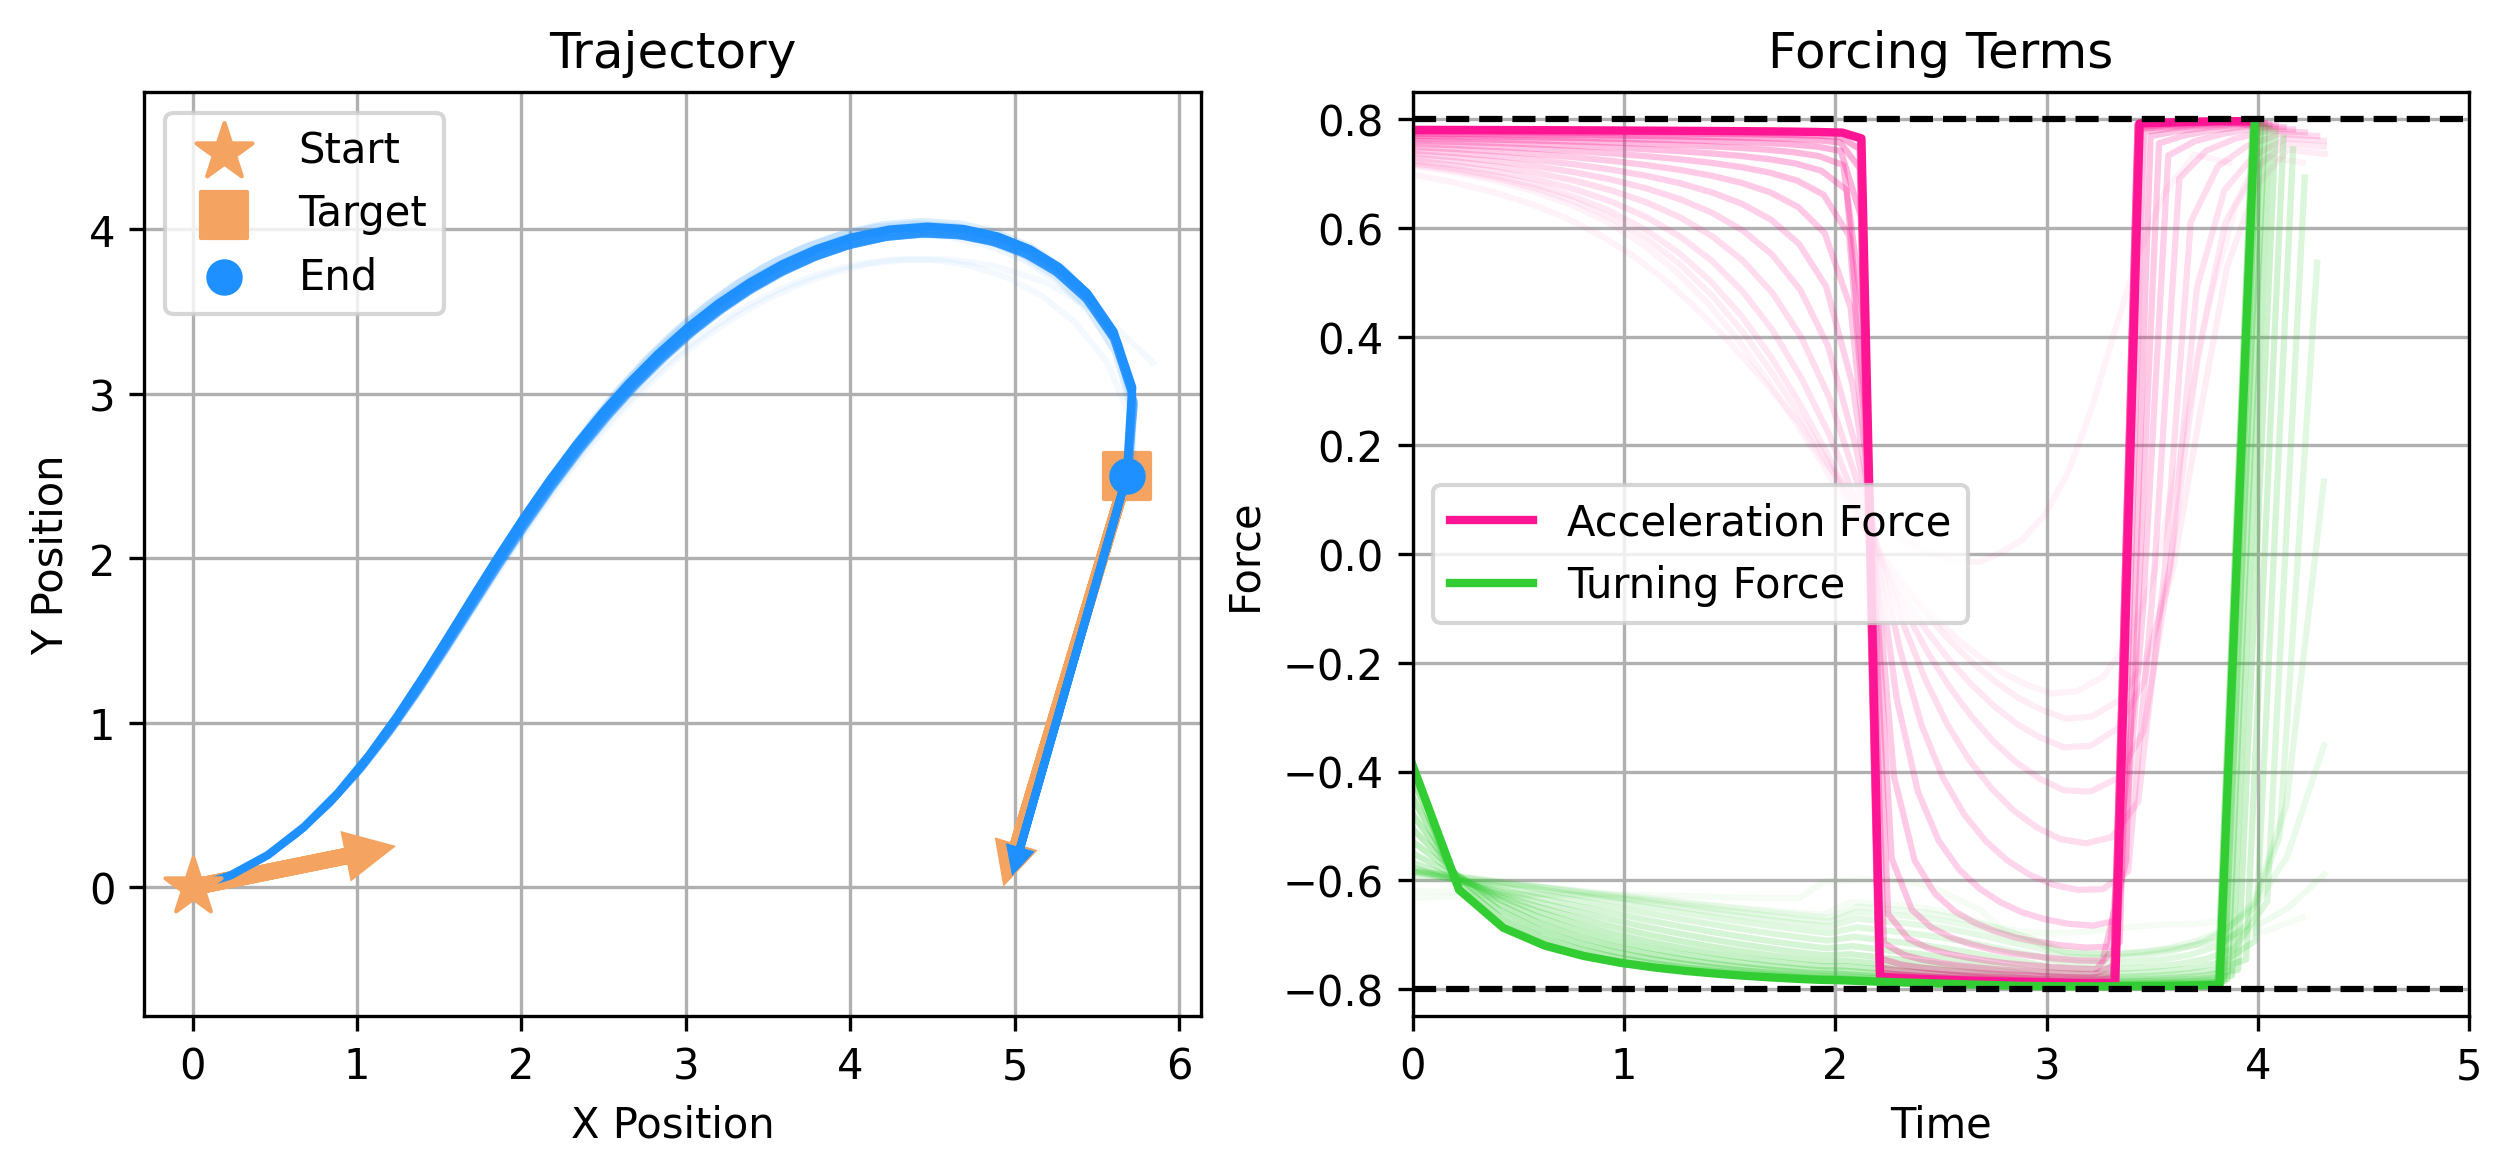

In [6]:
t0 = 0
t1 = 5       # designed for 5.5
dt_max = 0.25
n_steps = 2**np.ceil(np.log2((t1 - t0)/ dt_max)).astype(int)
print(f'Path has {n_steps} steps with size {(t1-t0)/n_steps:0.3g}s')

v0 = pt.tensor([0, 0, 0.2, 1, 1, t0])
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])

F_logits = nn.Parameter(0*pt.randn((n_steps, 3)))
F_logits, F_true, V_mat, ts, figaxs = optimizePath(v0, target, F_logits, lr=0.09, l2_rate=lambda x, t: -5*x, n_steps=1000, fine_tuning_steps=200)



In [40]:
V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_logits, target)
print(target)
print(V_mat[-1])

tensor([-1.1151,  1.8143, -1.1934,  0.2548,  1.0000])
tensor([-1.1071,  1.8187, -1.1758,  0.2575,  0.9495,  5.5429],
       grad_fn=<AddBackward0>)


Path has 32 steps with size 0.156s


/tmp/ipykernel_11836/3071460612.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = constrain(pt.tensor(2*pt.randn(5)))


Iteration 50, Target Dist: 1.6748595237731934, End Time: 5.8611650466918945, L2: 0.1786033809185028
Iteration 100, Target Dist: 1.0880693197250366, End Time: 6.769984722137451, L2: 0.26752614974975586
Iteration 150, Target Dist: 0.8575866222381592, End Time: 7.1282758712768555, L2: 0.318718284368515
Iteration 200, Target Dist: 0.72780841588974, End Time: 7.330196857452393, L2: 0.35806840658187866
Iteration 250, Target Dist: 0.6446995139122009, End Time: 7.455453395843506, L2: 0.3878125846385956
Iteration 300, Target Dist: 0.583868145942688, End Time: 7.543173789978027, L2: 0.4159904420375824
Iteration 350, Target Dist: 0.5439603924751282, End Time: 7.599203109741211, L2: 0.43514150381088257
Iteration 400, Target Dist: 0.5076536536216736, End Time: 7.641815185546875, L2: 0.4509941339492798
Iteration 450, Target Dist: 0.4746153950691223, End Time: 7.682440280914307, L2: 0.46946319937705994
Iteration 500, Target Dist: 0.4493618309497833, End Time: 7.7142486572265625, L2: 0.483848631381988

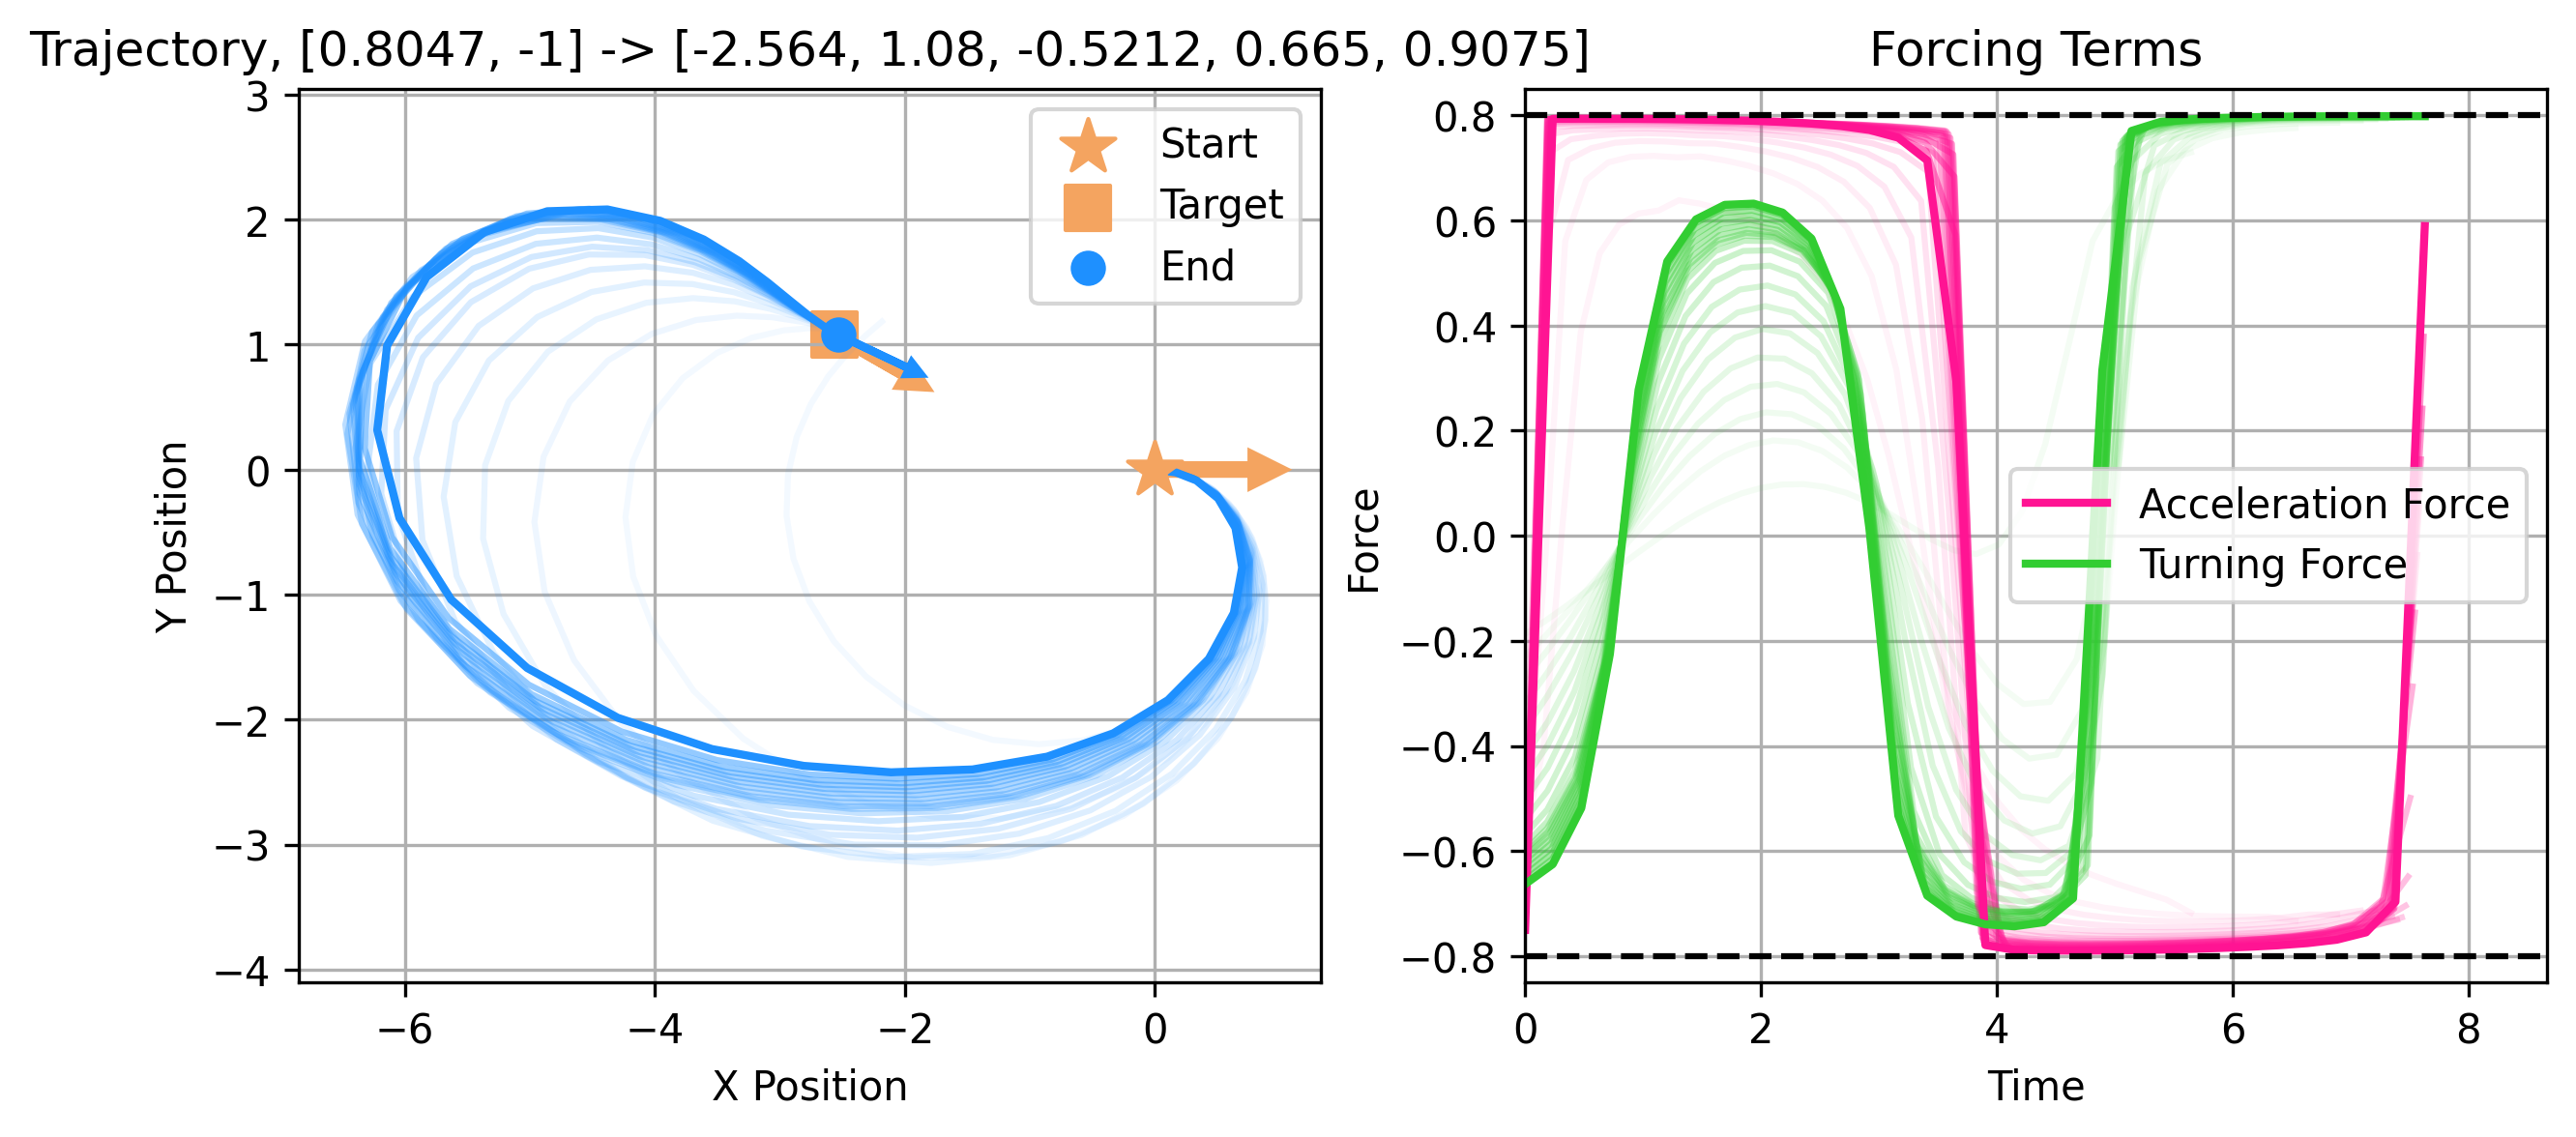

In [43]:
t0 = 0
t1 = 5       # designed for 5.5
dt_max = 0.25
n_steps = 2**np.ceil(np.log2((t1 - t0)/ dt_max)).astype(int)
print(f'Path has {n_steps} steps with size {(t1-t0)/n_steps:0.3g}s')

def constrain(vec: pt.tensor):
    vec[3] = pt.abs(vec[3])
    vec[4] = pt.clamp(vec[4], -1, 1)
    return vec

v0 = constrain(pt.cat([pt.tensor([0, 0, 0]), 2*pt.randn(2), pt.tensor([t0])]))
target = constrain(pt.tensor(2*pt.randn(5)))


F_logits = nn.Parameter(0*pt.randn((n_steps, 3)))

# F_mat, V_mat, figaxs = optimizePath(v0, target, F_mat, n_steps=1000, fine_tuning_steps=100,
#     lr = lambda x: 2e-2, 
#     # time_rate = lambda x, dist2: np.cos(np.pi * x) * -1e-5 if dist2 < 1 else 1e-8,
#     # l2_rate = lambda x, dist2: np.cos(np.pi * x) * 1e2 if dist2 < 1 else -3e0,
# )

# F_logits, F_true, traj, ts, figaxs = optimizePath(v0, target, F_logits,
#     show=False,
#     n_steps=500, 
#     fine_tuning_steps=100,
#     lr = 5e-2, 
#     # time_rate = 0,
#     l2_rate = lambda x, target_loss: -2*np.sin(np.pi*x),
# )

F_logits, F_true, traj, ts, figaxs = optimizePath(v0, target, F_logits, 
    show=False,
    lr=0.09, 
    l2_rate=lambda x, t: -2*np.sin(np.pi*x), 
    n_steps=1000, 
    fine_tuning_steps=400
)

tts = lambda tensor: "[" + ", ".join(f"{float(x):.4g}" for x in tensor) + "]"
figaxs = showTraj(traj, F_true, ts, target, figaxs=figaxs, show=True, ax1_Title=f'Trajectory, {tts(v0[3:5])} -> {tts(target)}', alpha=1.0)



Arclength = 3.159
S_0 = 0.804675281047821, S_1 = 0.6649801731109619
Expected time = (tensor([0.]), tensor([4.2991]))


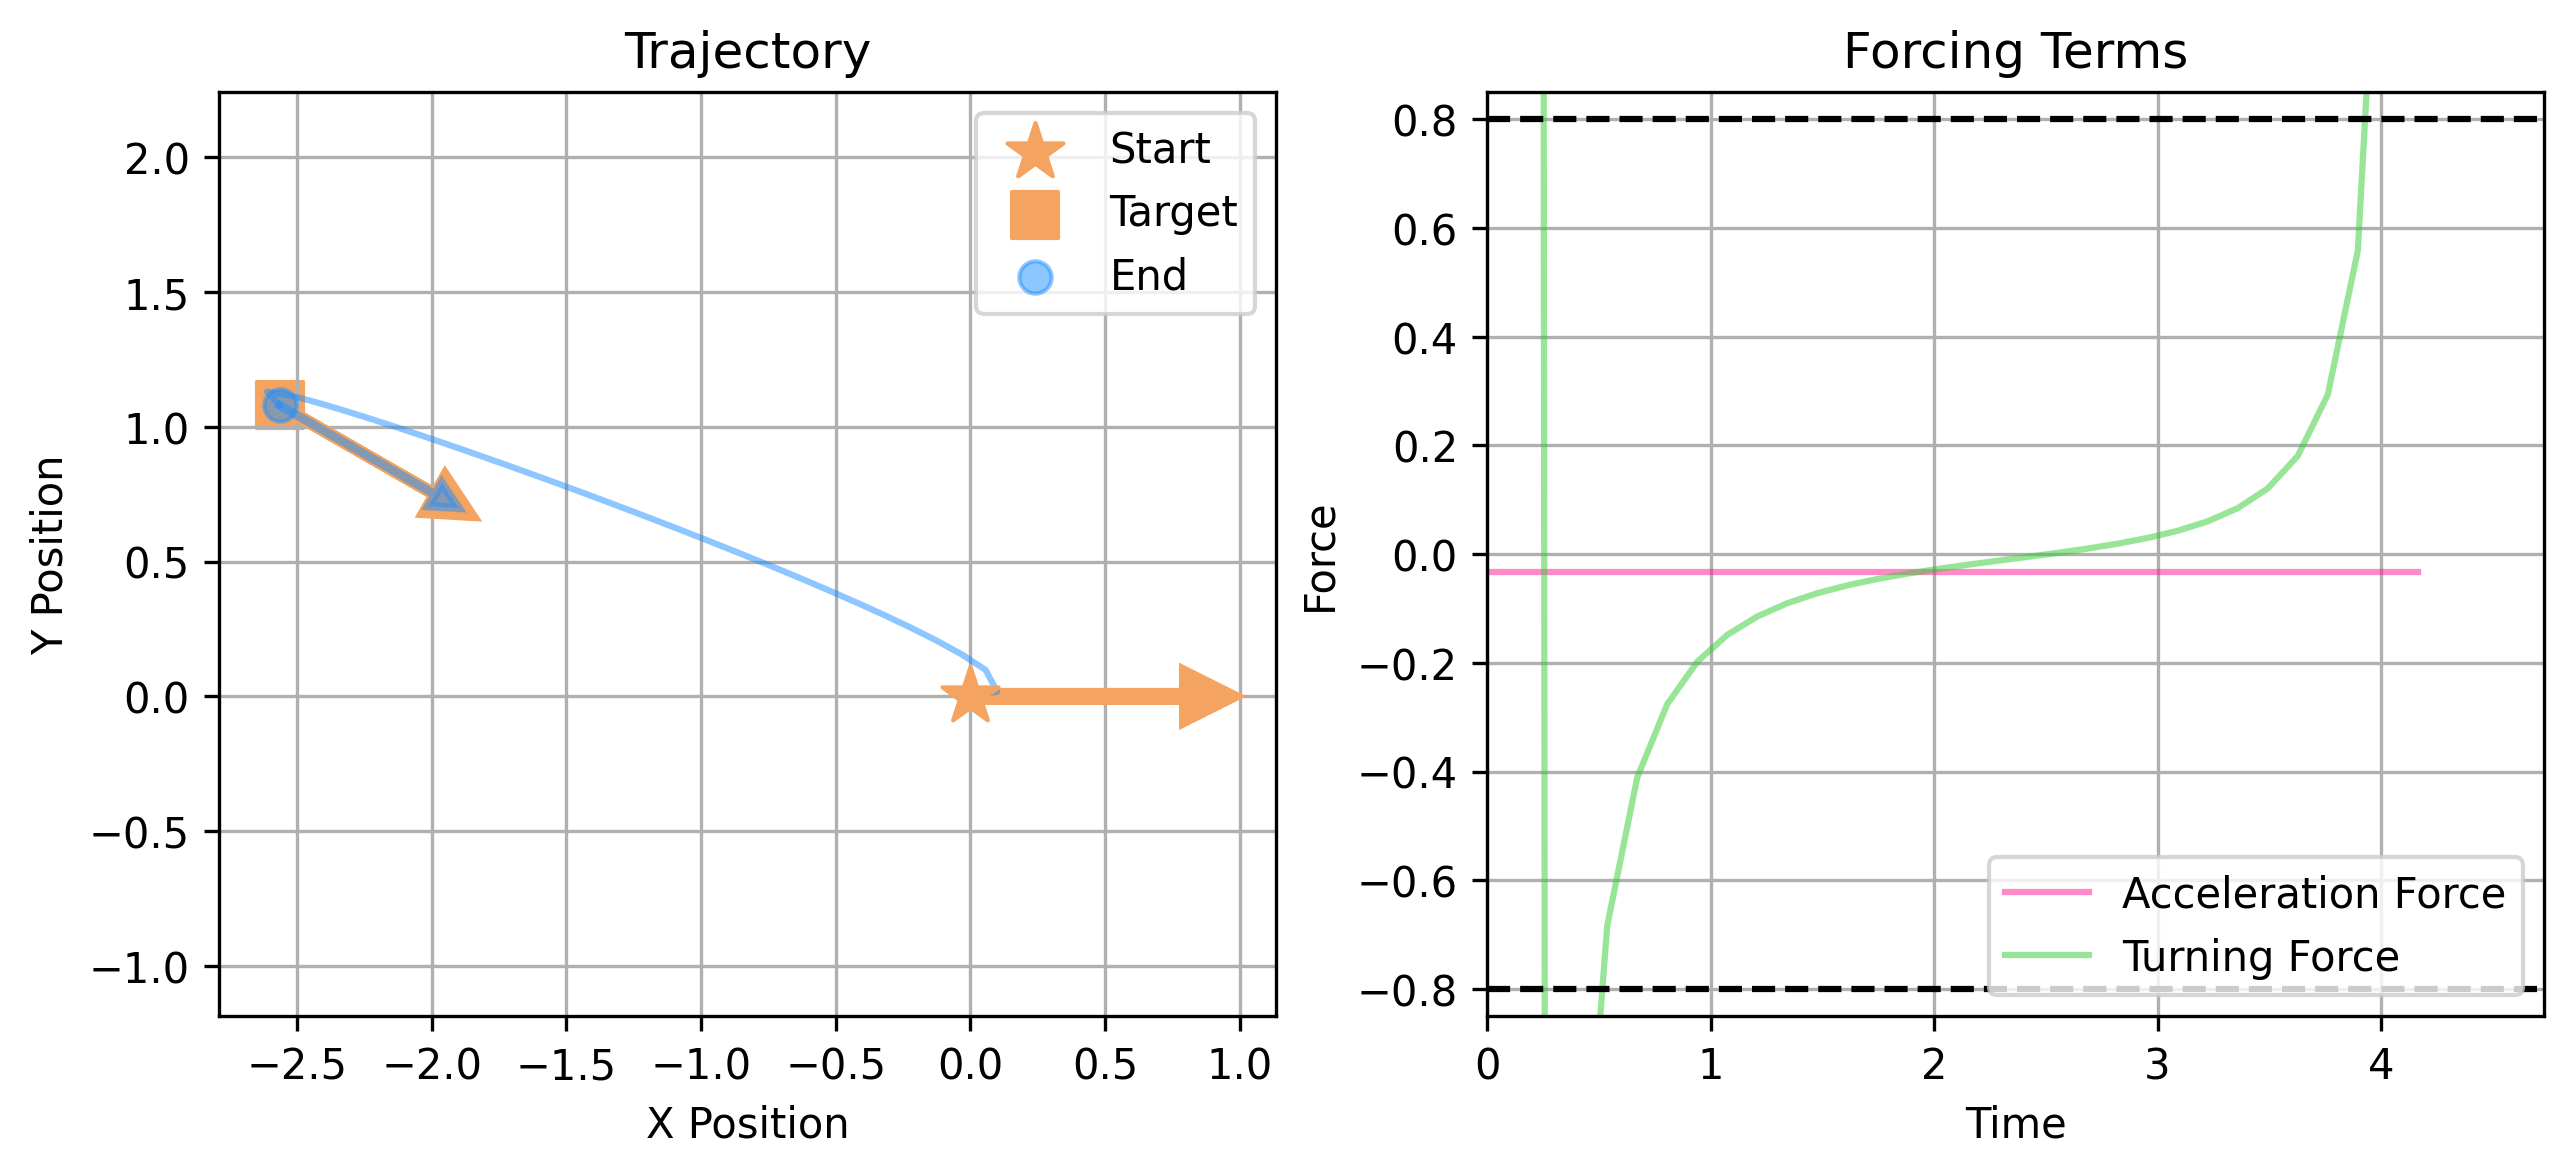

Iteration 50, Target Dist: 1.6506911516189575, End Time: 5.8660454750061035, L2: 0.18744540214538574
Iteration 100, Target Dist: 1.0918635129928589, End Time: 6.778565406799316, L2: 0.2729722857475281
Iteration 150, Target Dist: 0.8650040626525879, End Time: 7.1490631103515625, L2: 0.32185885310173035
Iteration 200, Target Dist: 0.7333333492279053, End Time: 7.363039493560791, L2: 0.36446672677993774
Iteration 250, Target Dist: 0.6533664464950562, End Time: 7.483598232269287, L2: 0.39495041966438293
Iteration 300, Target Dist: 0.5944358706474304, End Time: 7.565593242645264, L2: 0.4237082600593567
Iteration 350, Target Dist: 0.558769166469574, End Time: 7.61548376083374, L2: 0.44519293308258057
Iteration 400, Target Dist: 0.5290456414222717, End Time: 7.648692607879639, L2: 0.4598539173603058
Iteration 450, Target Dist: 0.49868619441986084, End Time: 7.684741497039795, L2: 0.47474971413612366
Iteration 500, Target Dist: 0.47231683135032654, End Time: 7.71851110458374, L2: 0.48918020725

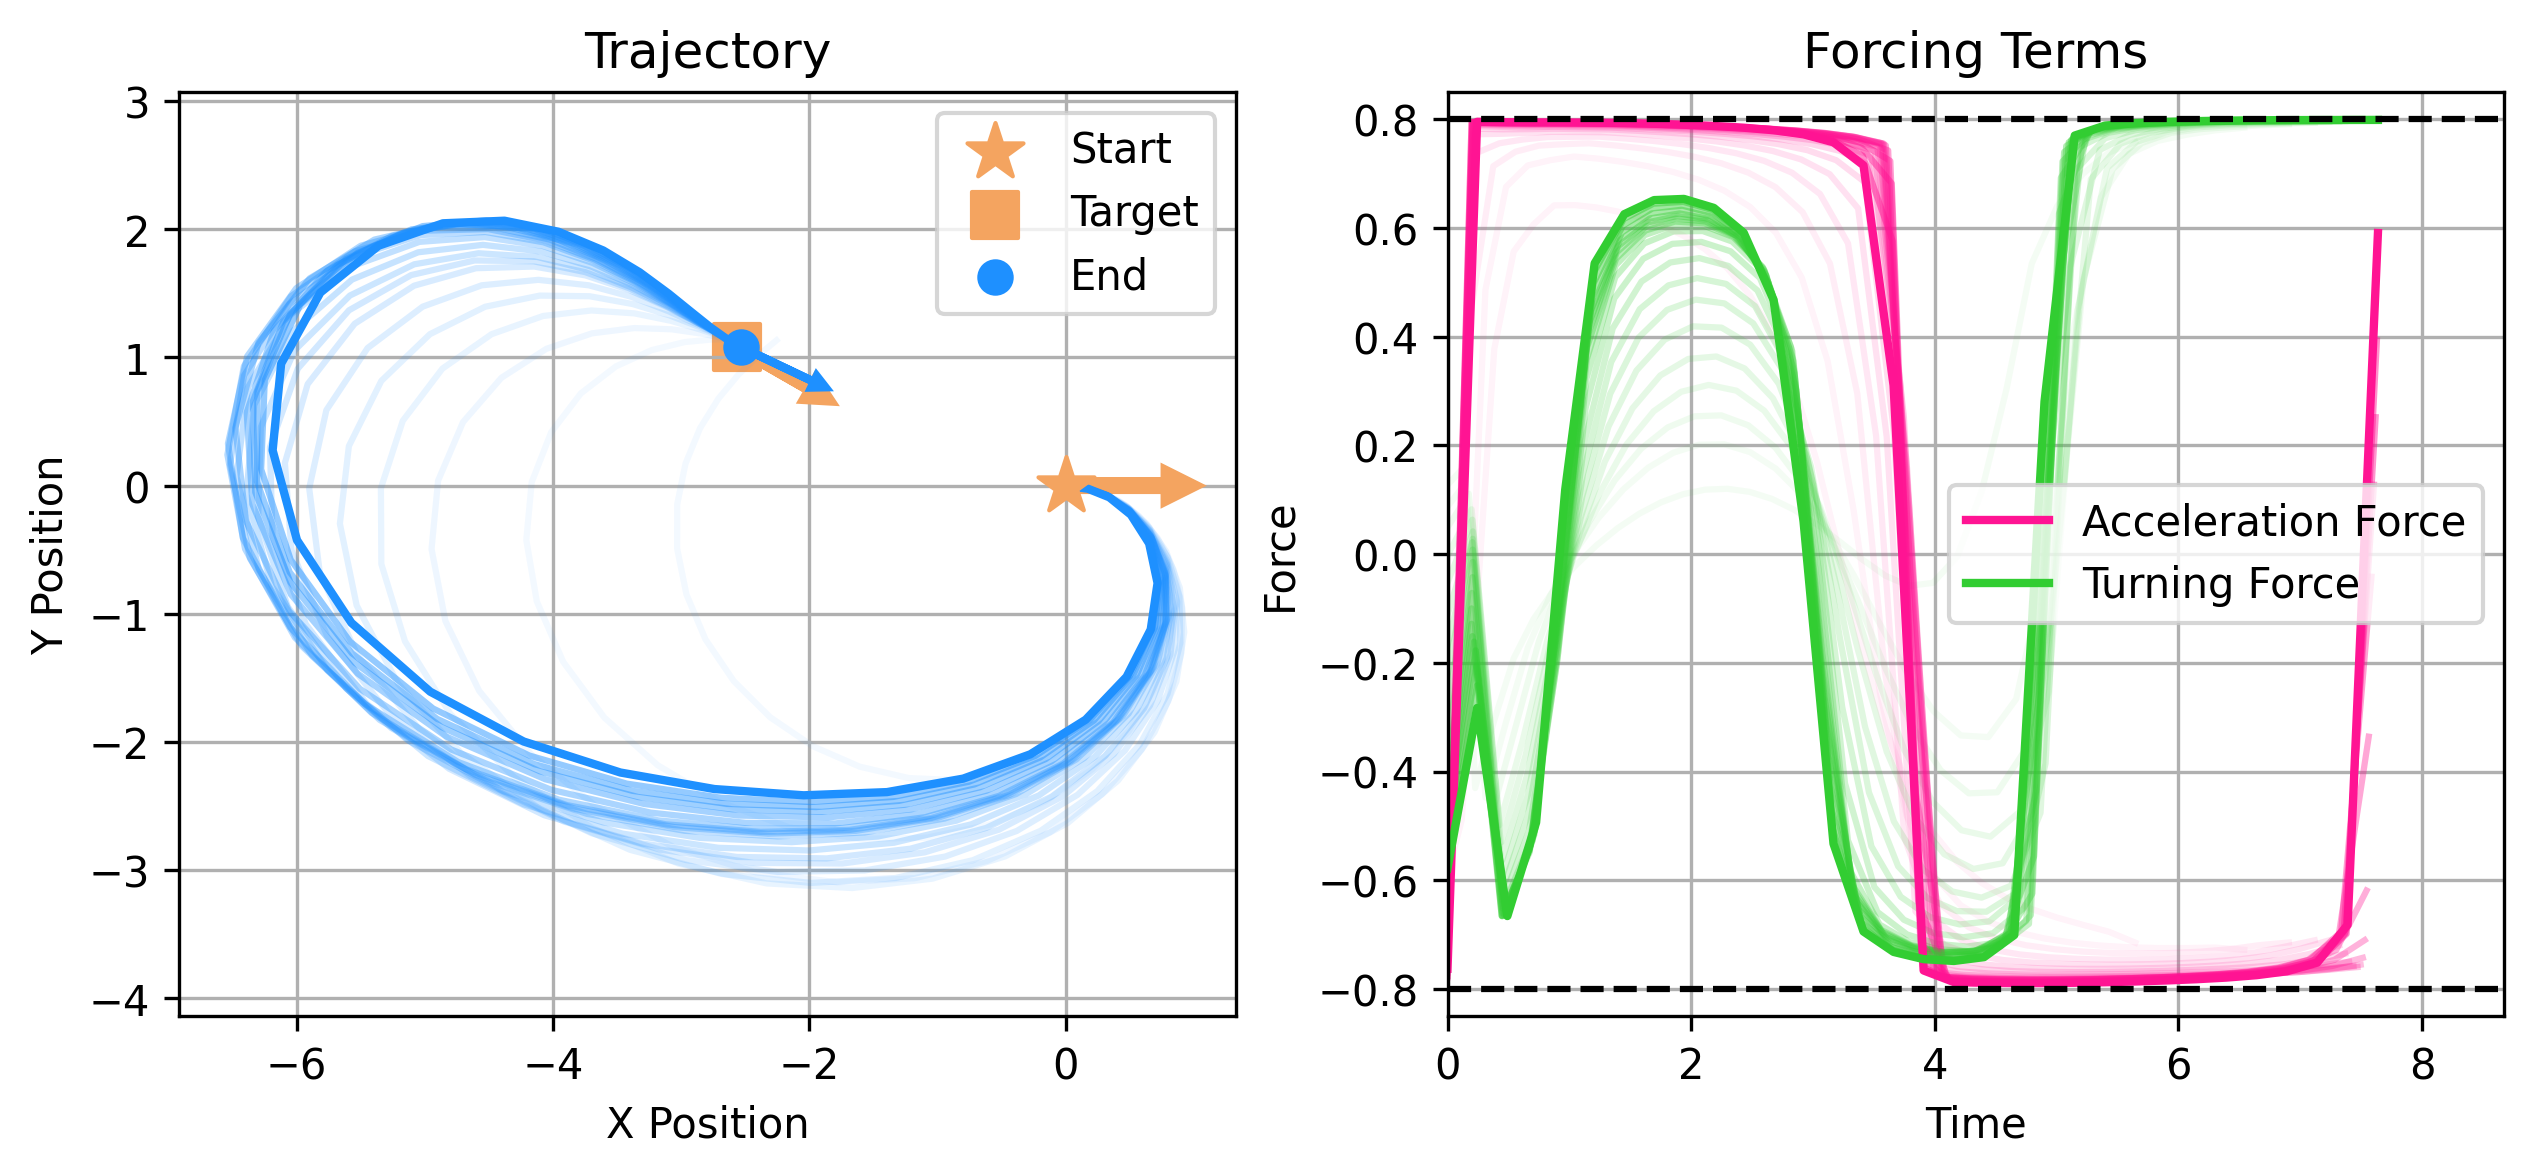

In [44]:
def inverse_interpolate(x, y, y_query):
    # Assume x and y are 1D and y is strictly increasing
    y_query = pt.atleast_1d(y_query)
    idx = pt.searchsorted(y, y_query.clamp(y[0], y[-1]), right=True)
    idx = idx.clamp(1, len(y)-1)

    x0, x1 = x[idx-1], x[idx]
    y0, y1 = y[idx-1], y[idx]

    # Linear interpolation to get x_query
    t = (y_query - y0) / (y1 - y0)
    x_query = x0 + t * (x1 - x0)
    return x_query

def make_bezier_ICS(start, end, divs=32):
    t = pt.linspace(0, 1, 256).unsqueeze(-1) # naive sample between 0 and 1

    v0 = start.unsqueeze(-2)
    v1 = end.unsqueeze(-2)

    x0, y0, a0, s0, w0 = v0[...,0], v0[...,1], v0[...,2], v0[...,3], v0[...,4]
    x1, y1, a1, s1, w1 = v1[...,0], v1[...,1], v1[...,2], v1[...,3], v1[...,4]
    
    # control points
    p0 = pt.tensor([x0, y0])
    p1 = pt.tensor([x0 + s0 * pt.cos(a0), y0 + s0 * pt.sin(a0)])
    p2 = pt.tensor([x1 - s1 * pt.cos(a1), y1 - s1 * pt.sin(a1)])
    p3 = pt.tensor([x1, y1])

    # Bezier interpolation equations
    bez = lambda t: (1-t)**3*p0 + 3*(1-t)**2*t*p1 + 3*(1-t)*t**2*p2 + t**3*p3
    bez_prime = lambda t: 3*(1-t)**2*(p1-p0) + 6*(1-t)*t*(p2-p1) + 3*t**2*(p3-p2)
    bez_prime2 = lambda t: 6*(1-t)*(p2-2*p1+p0) + 6*t*(p3-2*p2+p1)

    # naive sample -> evenly spaced sample

    B0_prime = bez_prime(t)
    L = pt.cumsum(pt.norm(B0_prime, dim=-1) / 256, -1)
    L_max = L[-1]
    t0 = s0*0
    t1 = t0 + 2*L_max / (s0 + s1)
    print(f'Arclength = {L_max:.4g}')
    print(f'S_0 = {s0.numpy()[0]}, S_1 = {s1.numpy()[0]}')
    print(f'Expected time = ({t0}, {t1})')

    s = pt.linspace(0, 1, divs+1)   # time paramatized var
    L_expected = (t1-t0)*((s-s**2/2)*s0+s**2/2*s1)  # expected distance with lerp speed from s0 to s1
    t_inverse = inverse_interpolate(t[...,0], L, L_expected).clamp_(0, 10).unsqueeze(-1).requires_grad_(True)
    tt = s.unsqueeze(-1)

    bez_xy = bez(t_inverse)
    bez_xy_prime = bez_prime(t_inverse)
    dt = (t1-t0) / (divs+1)

    # compute angle, speed and angular velocity of trajectory
    bez_a = pt.atan2(bez_xy_prime[...,1], bez_xy_prime[...,0]).unsqueeze(-1)
    bez_s = (1-tt) * s0 + tt * s1
    bez_w = pt.zeros_like(bez_a)
    bez_w = pt.autograd.grad(bez_a, t_inverse, grad_outputs=pt.ones_like(bez_a), create_graph=True)[0] / (t1-t0)

    F_phi = (s1-s0) / (t1-t0) * pt.ones_like(tt)
    F_psi = pt.autograd.grad(bez_w, t_inverse, grad_outputs=pt.ones_like(bez_a), create_graph=True)[0] / (t1-t0)
    F_dt = dt * pt.ones_like(tt)
    F_mat = pt.cat([F_phi, F_psi, F_dt], dim=-1)[...,:-1,:]

    ts = t0 + (t1 - t0) * tt
    return pt.cat([bez_xy, bez_a, bez_s, bez_w], dim=-1).detach(), p1, p2, ts, F_mat.detach()

bez, p1, p2, ts, F_mat = make_bezier_ICS(v0[:5], target)

# plt.scatter(bez[...,0], bez[...,1])
# plt.scatter(v0[...,0], v0[...,1], marker='*', color='sandybrown', s=200, zorder=6, label='Start')
# plt.scatter(target[...,0], target[...,1], marker='s', color='sandybrown', s=120, label='Target')
# plt.scatter(p1[...,0], p1[...,1], marker='^', color='sandybrown', s=120, label='Target')
# plt.scatter(p2[...,0], p2[...,1], marker='v', color='sandybrown', s=120, label='Target')
# plt.show()

# plt.plot(ts, bez[...,2], label='Angle')
# plt.plot(ts, bez[...,3], label='Speed')
# plt.plot(ts, bez[...,4], label='Angular Velocity')
# plt.legend()
# plt.show()

showTraj(bez, F_mat, ts, target)
F_init = 1.6 * pt.sigmoid(F_mat) - 0.8
F_init.requires_grad_(True)

F_logits, F_true, V_mat, ts, figaxs = optimizePath(v0, target, F_init, 
    lr=0.09, 
    l2_rate=lambda x, t: -2*np.sin(np.pi*x), 
    n_steps=1000, 
    fine_tuning_steps=400
)


In [63]:
# fig, (ax1, ax2) = figaxs
# fig
print(v0)
print(target)
print(bez[...,3])

tensor([0.0000, 0.0000, 0.0000, 0.8811, 1.0000, 0.0000])
tensor([ 0.9087, -1.5742,  0.0978,  0.7148, -1.0000])
tensor([1.2520, 1.1332, 1.0442, 0.9857, 0.9562, 0.9516, 0.9665, 0.9946, 1.0302,
        1.0688, 1.1065, 1.1407, 1.1694, 1.1911, 1.2049, 1.2101, 1.2063, 1.1933,
        1.1711, 1.1400, 1.1006, 1.0538, 1.0010, 0.9443, 0.8871, 0.8339, 0.7914,
        0.7680, 0.7726, 0.8123, 0.8898, 1.0035])


In [172]:
print(v0)

tensor([0.0000, 0.0000, 0.0000, 0.3709, 0.3709, 0.0000])


In [23]:
print(V_mat[-1,:])
print(V_mat[-1])
pt.set_printoptions(sci_mode=False)

# print(f'{F_mat:.3g}')

print(get_forcing(V_mat[:-1], F_logits))
print(ts)

tensor([-1.6187, -1.3584, -2.7829,  1.4665,  1.0032])
tensor([-1.6187, -1.3584, -2.7829,  1.4665,  1.0032])
tensor([[ 0.7864, -0.7899,  0.2400],
        [ 0.7885, -0.7895,  0.2399],
        [ 0.7910,  0.7804,  0.0735],
        [ 0.7913,  0.7835,  0.0386],
        [ 0.7914,  0.7852,  0.0305],
        [ 0.7912,  0.7855,  0.0355],
        [ 0.7907,  0.7835,  0.0897],
        [ 0.7908, -0.7843,  0.1996],
        [ 0.7915, -0.7843,  0.1830],
        [ 0.7919, -0.7842,  0.1602],
        [ 0.7902, -0.7853,  0.1229],
        [-0.7895,  0.7888,  0.0635],
        [-0.7882,  0.7919,  0.1939],
        [-0.7882,  0.7930,  0.2166],
        [-0.7889,  0.7937,  0.2172],
        [-0.7900,  0.7942,  0.2081],
        [-0.7912,  0.7945,  0.1897],
        [-0.7922,  0.7948,  0.1665],
        [-0.7929,  0.7950,  0.1494],
        [-0.7935,  0.7952,  0.1471],
        [ 0.7940,  0.7954,  0.1573],
        [ 0.7943,  0.7954,  0.1542],
        [ 0.7945,  0.7954,  0.1483],
        [ 0.7947,  0.7954,  0.1420],
    

In [167]:
tts = lambda tensor: "[" + ", ".join(f"{float(x):.3g}" for x in tensor) + "]"

print(tts(pt.tensor([0, 3.23423, 5])))

[0, 3.23, 5]
